# Anomaly Detection


In [1]:
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline

## Anomaly detection

The dataset contains two features - 
   * throughput (mb/s) and 
   * latency (ms) of response of each server.

While the servers were operating, data collected $m=307$ examples of how they were behaving, and thus have an unlabeled dataset $\{x^{(1)}, \ldots, x^{(m)}\}$. 
* It could be that the vast majority of these examples are "normal" (non-anomalous) examples of the servers operating normally, but there might also be some examples of servers acting anomalously within this dataset.

In [2]:
def load_data():
    X = np.load("data/X_part1.npy")
    X_val = np.load("data/X_val_part1.npy")
    y_val = np.load("data/y_val_part1.npy")
    return X, X_val, y_val


def load_data_multi():
    X = np.load("data/X_part2.npy")
    X_val = np.load("data/X_val_part2.npy")
    y_val = np.load("data/y_val_part2.npy")
    return X, X_val, y_val


def multivariate_gaussian(X, mu, var):
    """
    Computes the probability density function of the examples X under the multivariate gaussian
    distribution with parameters mu and var. If var is a matrix, it is treated as the covariance matrix. 
	If var is a vector, it is treated as the var values of the variances in each dimension
    """

    k = len(mu)

    if var.ndim == 1:
        var = np.diag(var)

    X = X - mu
    p = (
        (2 * np.pi) ** (-k / 2)
        * np.linalg.det(var) ** (-0.5)
        * np.exp(-0.5 * np.sum(np.matmul(X, np.linalg.pinv(var)) * X, axis=1))
    )

    return p


def visualize_fit(X, mu, var):
    """
    This visualization shows the probability density function of the Gaussian distribution. 
	Each example has a location (x1, x2) that depends on its feature values.
    """

    X1, X2 = np.meshgrid(np.arange(0, 35.5, 0.5), np.arange(0, 35.5, 0.5))
    Z = multivariate_gaussian(np.stack([X1.ravel(), X2.ravel()], axis=1), mu, var)
    Z = Z.reshape(X1.shape)

    plt.plot(X[:, 0], X[:, 1], "bx")

    if np.sum(np.isinf(Z)) == 0:
        plt.contour(X1, X2, Z, levels=10 ** (np.arange(-20.0, 1, 3)), linewidths=1)

    plt.title("The Gaussian contours of the distribution fit to the dataset")
    plt.ylabel("Throughput (mb/s)")
    plt.xlabel("Latency (ms)")


In [3]:
X_train, X_val, y_val = load_data()


#### View the variables

In [4]:
print("The first 5 elements of X_train are:\n", X_train[:5])


The first 5 elements of X_train are:
 [[13.04681517 14.74115241]
 [13.40852019 13.7632696 ]
 [14.19591481 15.85318113]
 [14.91470077 16.17425987]
 [13.57669961 14.04284944]]


In [5]:
print("The first 5 elements of X_val are\n", X_val[:5])


The first 5 elements of X_val are
 [[15.79025979 14.9210243 ]
 [13.63961877 15.32995521]
 [14.86589943 16.47386514]
 [13.58467605 13.98930611]
 [13.46404167 15.63533011]]


In [6]:
print("The first 5 elements of y_val are\n", y_val[:5])


The first 5 elements of y_val are
 [0 0 0 0 0]


#### Check the dimensions of your variables

In [7]:
print("The shape of X_train is:", X_train.shape)
print("The shape of X_val is:", X_val.shape)
print("The shape of y_val is: ", y_val.shape)


The shape of X_train is: (307, 2)
The shape of X_val is: (307, 2)
The shape of y_val is:  (307,)


#### Visualize your data

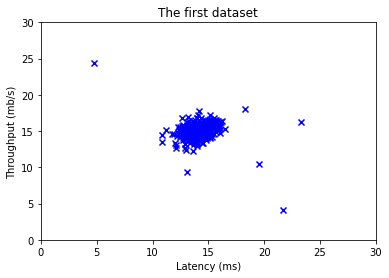

In [8]:
# the 'marker' and 'c' parameters
plt.scatter(X_train[:, 0], X_train[:, 1], marker="x", c="b")

plt.title("The first dataset")
plt.ylabel("Throughput (mb/s)")
plt.xlabel("Latency (ms)")
plt.axis([0, 30, 0, 30])
plt.show()


### Gaussian distribution


* Given a training set $\{x^{(1)}, ..., x^{(m)}\}$ estimate the Gaussian distribution for each
of the features $x_i$. 

* The Gaussian distribution is given by

   $$ p(x ; \mu,\sigma ^2) = \frac{1}{\sqrt{2 \pi \sigma ^2}}\exp^{ - \frac{(x - \mu)^2}{2 \sigma ^2} }$$

   where $\mu$ is the mean and $\sigma^2$ controls the variance.
   
* For each feature $i = 1\ldots n$, you need to find parameters $\mu_i$ and $\sigma_i^2$ that fit the data in the $i$-th dimension $\{x_i^{(1)}, ..., x_i^{(m)}\}$ (the $i$-th dimension of each example).


Esimate the parameters, ($\mu_i$, $\sigma_i^2$), of the $i$-th
feature by using the following equations. 

use:

$$\mu_i = \frac{1}{m} \sum_{j=1}^m x_i^{(j)}$$

and for the variance use:

$$\sigma_i^2 = \frac{1}{m} \sum_{j=1}^m (x_i^{(j)} - \mu_i)^2$$

In [9]:
def estimate_gaussian(X):
    """
    Calculates mean and variance of all features
    in the dataset

    Args:
        X: (m, n) Data matrix

    Returns:
        mu: (n,) Mean of all features
        var: (n,) Variance of all features
    """

    m, n = X.shape

    mu = 1 / m * np.sum(X, axis=0)
    var = 1 / m * np.sum((X - mu) ** 2, axis=0)
    return mu, var


In [10]:
# Estimate mean and variance of each feature
mu, var = estimate_gaussian(X_train)

print("Mean of each feature:", mu)
print("Variance of each feature:", var)


Mean of each feature: [14.11222578 14.99771051]
Variance of each feature: [1.83263141 1.70974533]


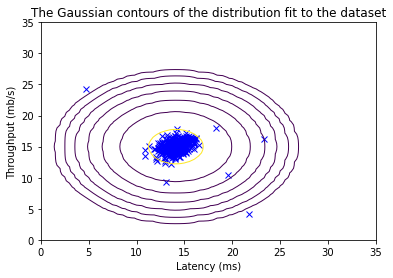

In [11]:
# Returns the density of the multivariate normal
# at each data point (row) of X_train
p = multivariate_gaussian(X_train, mu, var)

# Plotting code
visualize_fit(X_train, mu, var)


### Selecting the threshold $\epsilon$


* The low probability examples are more likely to be the anomalies in our dataset. 
* One way to determine which examples are anomalies is to select a threshold based on a cross validation set. 


$\{(x_{\rm cv}^{(1)}, y_{\rm cv}^{(1)}),\ldots, (x_{\rm cv}^{(m_{\rm cv})}, y_{\rm cv}^{(m_{\rm cv})})\}$, where the label $y=1$ corresponds to an anomalous example, and $y=0$ corresponds to a normal example. 
* For each cross validation example, we will compute $p(x_{\rm cv}^{(i)})$. The vector of all of these probabilities $p(x_{\rm cv}^{(1)}), \ldots, p(x_{\rm cv}^{(m_{\rm cv)}})$ is passed to `select_threshold` in the vector `p_val`. 
* The corresponding labels $y_{\rm cv}^{(1)}, \ldots, y_{\rm cv}^{(m_{\rm cv)}}$ is passed to the same function in the vector `y_val`.

- Calculate the F1 score from choosing `epsilon` as the threshold and place the value in `F1`. 
    - $x$ has a low probability $p(x) < \varepsilon$, then it is classified as an anomaly. 
        
    - Compute precision and recall by: 
        $$
        \begin{aligned}
        prec&=&\frac{tp}{tp+fp}\\
        rec&=&\frac{tp}{tp+fn},
        \end{aligned}
        $$ 
        where
        - $tp$ is the number of true positives: the ground truth label says it’s an anomaly and the algorithm correctly classified it as an anomaly.
        - $fp$ is the number of false positives: the ground truth label says it’s not an anomaly, but the algorithm incorrectly classified it as an anomaly.
        - $fn$ is the number of false negatives: the ground truth label says it’s an anomaly, but the algorithm incorrectly classified it as not being anomalous.

  - The $F_1$ score is computed using precision ($prec$) and recall ($rec$) as follows:

    $$F_1 = \frac{2\cdot prec \cdot rec}{prec + rec}$$ 

In order to compute $tp$, $fp$ and $fn$, a vectorized implementation must be used rather than loop over all the examples.

In [12]:
def select_threshold(y_val, p_val):
    """
    Finds the best threshold to use for selecting outliers
    based on the results from a validation set (p_val)
    and the ground truth (y_val)

    Args:
        y_val: Ground truth on validation set
        p_val: Results on validation set

    Returns:
        epsilon: Threshold chosen
        F1: F1 score by choosing epsilon as threshold
    """

    best_epsilon = 0
    best_F1 = 0
    F1 = 0

    step_size = (max(p_val) - min(p_val)) / 1000

    for epsilon in np.arange(min(p_val), max(p_val), step_size):

        predictions = p_val < epsilon
        tp = np.sum((predictions == 1) & (y_val == 1))
        fn = np.sum((predictions == 0) & (y_val == 1))
        fp = sum((predictions == 1) & (y_val == 0))
        prec = tp / (tp + fp)
        rec = tp / (tp + fn)
        F1 = 2 * prec * rec / (prec + rec)

        if F1 > best_F1:
            best_F1 = F1
            best_epsilon = epsilon

    return best_epsilon, best_F1


In [13]:
p_val = multivariate_gaussian(X_val, mu, var)
epsilon, F1 = select_threshold(y_val, p_val)

print("Best epsilon found using cross-validation: %e" % epsilon)
print("Best F1 on Cross Validation Set: %f" % F1)


/tmp/ipykernel_37542/2817313625.py:28: RuntimeWarning: invalid value encountered in long_scalars
  prec = tp / (tp + fp)


Best epsilon found using cross-validation: 8.990853e-05
Best F1 on Cross Validation Set: 0.875000


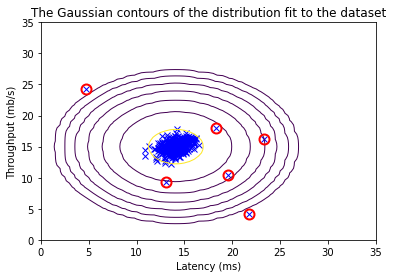

In [14]:
# Find the outliers in the training set
outliers = p < epsilon

# Visualize the fit
visualize_fit(X_train, mu, var)

# Draw a red circle around those outliers
plt.plot(
    X_train[outliers, 0],
    X_train[outliers, 1],
    "ro",
    markersize=10,
    markerfacecolor="none",
    markeredgewidth=2,
)


### High dimensional dataset

In this dataset, each example is described by 11 features, capturing many more properties of your compute servers.

- The `load_data()` function shown below loads the data into variables `X_train_high`, `X_val_high` and `y_val_high`
    - `_high` is meant to distinguish these variables from the ones used in the previous part
    - `X_train_high` to fit Gaussian distribution 
    - `X_val_high` and `y_val_high` as a cross validation set to select a threshold and determine anomalous vs normal examples

In [15]:
X_train_high, X_val_high, y_val_high = load_data_multi()

In [16]:
print("The shape of X_train_high is:", X_train_high.shape)
print("The shape of X_val_high is:", X_val_high.shape)
print("The shape of y_val_high is: ", y_val_high.shape)


The shape of X_train_high is: (1000, 11)
The shape of X_val_high is: (100, 11)
The shape of y_val_high is:  (100,)


#### Anomaly detection 

* Estimate the Gaussian parameters ($\mu_i$ and $\sigma_i^2$)
* Evaluate the probabilities for both the training data `X_train_high` from which the Gaussian parameters are estimated, as well as for the the cross-validation set `X_val_high`. 
* Finally, use `select_threshold` to find the best threshold $\varepsilon$. 

In [17]:
# Estimate the Gaussian parameters
mu_high, var_high = estimate_gaussian(X_train_high)

# Evaluate the probabilites for the training set
p_high = multivariate_gaussian(X_train_high, mu_high, var_high)

# Evaluate the probabilites for the cross validation set
p_val_high = multivariate_gaussian(X_val_high, mu_high, var_high)

# Find the best threshold
epsilon_high, F1_high = select_threshold(y_val_high, p_val_high)

print("Best epsilon found using cross-validation: %e" % epsilon_high)
print("Best F1 on Cross Validation Set:  %f" % F1_high)
print("# Anomalies found: %d" % sum(p_high < epsilon_high))


Best epsilon found using cross-validation: 1.377229e-18
Best F1 on Cross Validation Set:  0.615385
# Anomalies found: 117


/tmp/ipykernel_37542/2817313625.py:28: RuntimeWarning: invalid value encountered in long_scalars
  prec = tp / (tp + fp)
